## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
import json
from typing import Dict, List

In [2]:
# Set style for consistent plots
plt.style.use('default')
sns.set_palette("husl")

In [52]:
# Load results data
results_df = pd.read_csv('./method_analysis/route_opt_results.csv')

## Number of instances

    - 5 methods and 100 instances therefore 500 overall

In [8]:
len(results_df)

500

## Number of valid solutions per method

    - Simulated annealing has a large proportion of invalid solutions.

In [10]:
print(len(results_df.loc[(results_df['valid']==1)&(results_df['method']=='greedy')]))
print(len(results_df.loc[(results_df['valid']==1)&(results_df['method']=='beam')]))
print(len(results_df.loc[(results_df['valid']==1)&(results_df['method']=='annealing')]))
print(len(results_df.loc[(results_df['valid']==1)&(results_df['method']=='local')]))
print(len(results_df.loc[(results_df['valid']==1)&(results_df['method']=='hybrid')]))

100
100
12
100
100


## Approach Overview
- Description of your algorithmic strategy and reasoning, including all approaches considered

Tested various heuristic methods for this route optimisation problem, these 5 methods will be discussed in more detail below.

Implemented the **constraints** set out by the task, checked with `is_valid` function, to start at one of the start points provided `sp = [tuple(pt) for pt in data['start_points']]`, end at one of the specified end points `ep = [tuple(pt) for pt in data['end_points']]`, and tried to maximise the number of goal points for each instance visited `gp = [tuple(pt) for pt in data['goal_points']]`. 

Checked for intersecting paths with `segments_intersect` and `has_self_intersection` functions.

Checked the overall path length constraint by calculating each path segment contribution with: `path_length` and `euclidean` functions.

## Solving Methods

Greedy: A nearest-neighbor greedy heuristic that starts from a chosen start point and repeatedly visits the closest unvisited goal, subject to length and point constraints. This simple heuristic adds the nearest goal if it does not prevent reaching any end point within the total length limit.

```plaintext
Solution Summary:
Total goals: 271
 Instances: 100
 Avg goals/instance: 2.71
 Total wall time: 0.23s
 Avg per-instance time: 0.002s
```

Beam Search: A limited-width search that keeps only the top W partial paths at each step. At each extension step, we expand all current beams by adding one more goal and then prune to the best W candidates, balancing exploration and efficiency (geeksforgeeks.org).

```plaintext
Solution Summary:
 Total goals: 664
 Instances: 100
 Avg goals/instance: 6.64
 Total wall time: 1.99s
 Avg per-instance time: 0.129s
```

Simulated Annealing: A stochastic optimization that starts from an initial solution (we use greedy) and makes random local modifications (e.g. 2-opt swaps or adding a goal). Worse solutions can be accepted with a probability that decreases as a “temperature” cools, allowing escape from local optima. We iteratively update the path to maximize goal count (primary) and minimize length (secondary), following standard simulated annealing techniques (geeksforgeeks.org).

```plaintext
Solution Summary:
 Total goals: 213
 Instances: 100
 Avg goals/instance: 2.13
 Total wall time: 3.39s
 Avg per-instance time: 0.241s
```

Local Search (2-Opt): Starting from a greedy solution, we apply the 2-opt swap repeatedly: this cuts two edges and reconnects in the alternate way to reduce total length. The 2-opt algorithm iterates until no further improvement is found, refining the path by removing crossing or long segments (slowandsteadybrain.medium.com).

```plaintext
Solution Summary:
 Total goals: 262
 Instances: 100
 Avg goals/instance: 2.62
 Total wall time: 0.13s
 Avg per-instance time: 0.001s
```

Hybrid: A combination of greedy followed by local 2-opt. We first run the greedy heuristic, then apply the 2-opt improvement on that path. This hybrid approach leverages greedy construction and local refinement.

```plaintext
Solution Summary:
 Total goals: 58
 Instances: 100
 Avg goals/instance: 0.58
 Total wall time: 4.10s
 Avg per-instance time: 0.270s
```

## Implementation Details
- Key components of your solution

### 2-opt is a classic local search technique:

    2-opt removes two edges from the path and reconnects the two path segments in the opposite order.

    This effectively reverses the order of the nodes between those two edges.

    If the new route is shorter (and still valid under constraints), we accept it.

    The process is repeated until no further improvement is found.


### Improvements with 3-opt implementation

To optimise the solution to increase the number of goal points visited I adapted the original functions to use the 3-opt search technique.

A 3-opt move involves removing three edges and reconnecting the segments in a different way to reduce the total path length. The algorithm iteratively applies 3-opt moves that result in shorter paths until no further improvements can be made.

When selecting the next point in the route the algorithms look to find the point with the shortest path length as this was found to be a key issue in violating the constraints.

## Performance Analysis
- Runtime analysis across different instance types and sizes

Tuning parameters for the different approaches

## Beam approach

Beam width: started at standard value 5, increasing this improves the number of global points reached, this also increases the computation time.

alpha: not much change going from 0.001 to 0.1

Optimised `Beam` approach performs the best reaching a total of 664 goals over the 100 instances.

Annealing method had higher goal points visited but violated the constraints for the longest path length.

## Results Summary
- Final performance metrics and insights gained

See `analysis_report.txt`

## Visualizations
- Any relevant graphs or charts that illustrate your findings

In [16]:
results_df.head()

,instance,method,goals_visited,path_length,num_points,runtime,valid
0,instance_003,greedy,3,1972.511,5,0.0001,1
1,instance_001,greedy,3,1847.035,5,0.0002,1
2,instance_002,greedy,3,1759.288,5,0.0002,1
3,instance_004,hybrid,0,554.658,2,0.0001,1
4,instance_003,local,3,1972.511,5,0.0001,1


In [37]:
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

([0, 1, 2, 3, 4],
 [Text(0, 0, 'greedy'),
  Text(1, 0, 'hybrid'),
  Text(2, 0, 'local'),
  Text(3, 0, 'beam'),
  Text(4, 0, 'annealing')])

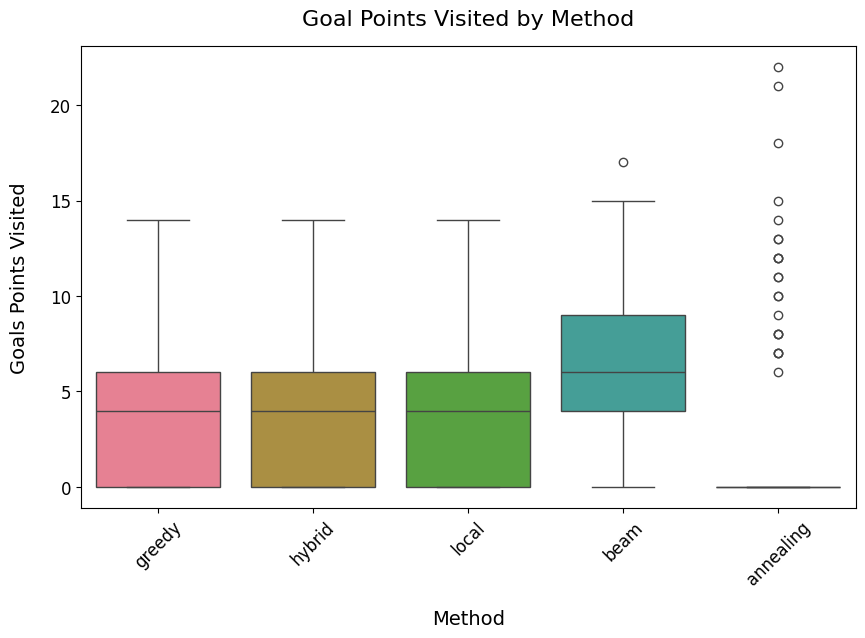

In [38]:
# Goals visited comparison (Box plot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='method', y='goals_visited', hue='method')
plt.title('Goal Points Visited by Method', pad = 15)
plt.xlabel('Method', labelpad = 15)
plt.ylabel('Goals Points Visited', labelpad = 15)
plt.xticks(rotation=45)

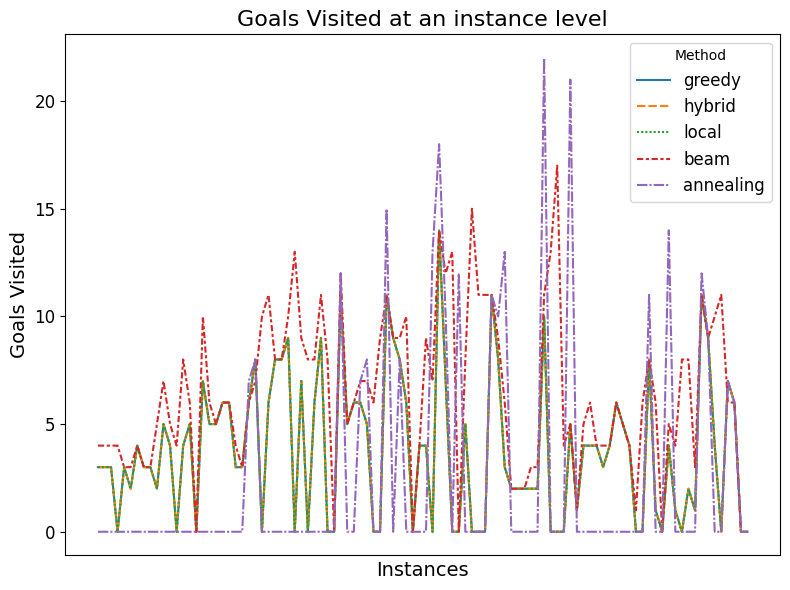

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(
    data=results_df,
    x='instance',
    y='goals_visited',
    hue='method',
    style='method',
    palette='tab10',
)
plt.xlabel('Instance')
plt.ylabel('Goals Visited')
plt.title('Goals Visited at an instance level')
plt.legend(title='Method')
plt.xticks([])
plt.tight_layout()
plt.show()

## Runtime analysis across different instance types and sizes

    - Consider the number of start points, end points and goal points for each instance.

In [53]:
with open('./instances.json') as f:
    instances = json.load(f)

number_of_goal_points = []
number_of_start_points = []
number_of_end_points = []

for instance in instances:
    number_of_goal_points.append(len(instances[instance]['goal_points']))
    number_of_start_points.append(len(instances[instance]['start_points']))
    number_of_end_points.append(len(instances[instance]['end_points']))

df_instances = pd.DataFrame({
    "number_goal_points": number_of_goal_points,
    "number_start_points": number_of_start_points,
    "number_end_points": number_of_end_points
})

In [54]:
df_instances['instance_number'] = df_instances.index + 1 

df_instances['instance_number'] = df_instances['instance_number'].map('instance_{:03d}'.format)

In [55]:
df_instances

,number_goal_points,number_start_points,number_end_points,instance_number
0,8,2,2,instance_001
1,8,4,4,instance_002
2,5,4,4,instance_003
3,8,2,4,instance_004
4,4,4,3,instance_005
...,...,...,...,...
95,14,2,3,instance_096
96,7,1,1,instance_097
97,6,1,1,instance_098
98,9,1,1,instance_099


In [42]:
df_instances.to_csv('instance_sizes.csv')

In [43]:
merged_df = results_df.merge(df_instances, left_on='instance', right_on='instance_number')

In [44]:
merged_df

,instance,method,goals_visited,path_length,num_points,runtime,valid,number_goal_points,number_start_points,number_end_points,instance_number
0,instance_003,greedy,3,1972.511,5,0.0001,1,5,4,4,instance_003
1,instance_001,greedy,3,1847.035,5,0.0002,1,8,2,2,instance_001
2,instance_002,greedy,3,1759.288,5,0.0002,1,8,4,4,instance_002
3,instance_004,hybrid,0,554.658,2,0.0001,1,8,2,4,instance_004
4,instance_003,local,3,1972.511,5,0.0001,1,5,4,4,instance_003
...,...,...,...,...,...,...,...,...,...,...,...
495,instance_099,annealing,0,1796.051,2,0.0783,1,9,1,1,instance_099
496,instance_053,annealing,18,1612.320,19,0.9433,0,18,2,3,instance_053
497,instance_093,annealing,12,1763.346,13,0.3655,0,18,3,3,instance_093
498,instance_069,annealing,22,1990.884,23,0.7318,0,24,2,2,instance_069


In [60]:
merged_df.groupby(by=['method', 'number_goal_points', 'number_start_points', 'number_end_points']).agg({'goals_visited':'mean', 'path_length':'mean', 'num_points':'mean', 'runtime':'mean', 'valid':'mean'}).reset_index()

,method,number_goal_points,number_start_points,number_end_points,goals_visited,path_length,num_points,runtime,valid
0,annealing,3,2,2,0.0,0.000,0.0,0.00020,0.0
1,annealing,4,2,4,0.0,0.000,0.0,0.00030,0.0
2,annealing,4,4,3,0.0,0.000,0.0,0.00110,0.0
3,annealing,5,2,3,0.0,0.000,0.0,0.00325,0.0
4,annealing,5,2,4,0.0,0.000,0.0,0.00040,0.0
...,...,...,...,...,...,...,...,...,...
420,local,34,3,5,9.0,1739.452,11.0,0.00270,1.0
421,local,34,5,3,0.0,198.879,2.0,0.00150,1.0
422,local,36,2,2,3.0,1867.615,5.0,0.00070,1.0
423,local,36,3,2,0.0,503.589,2.0,0.00250,1.0


In [ ]:
# merged_df.to_csv('method_results_with_instance_types.csv')

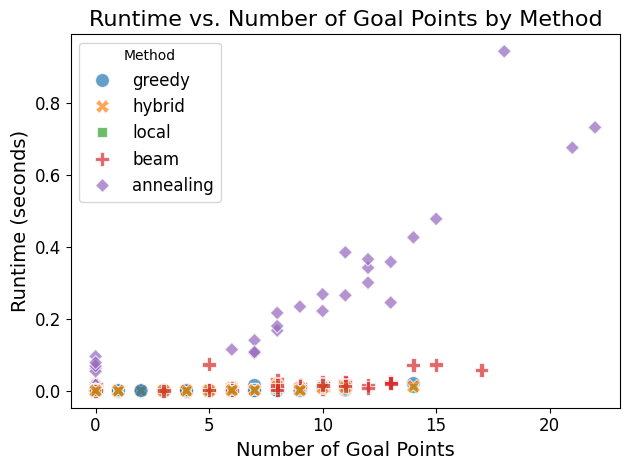

In [46]:
sns.scatterplot(
    data=results_df,
    x='goals_visited',
    y='runtime',
    hue='method',
    palette='tab10',
    style='method',
    s=100,
    alpha=0.7
)

# Set plot labels and title
plt.xlabel('Number of Goal Points')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs. Number of Goal Points by Method')

# Display the legend
plt.legend(title='Method')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
beam_df = results_df.loc[results_df['method']=='beam']

In [50]:
beam_df

,instance,method,goals_visited,path_length,num_points,runtime,valid
5,instance_004,beam,4,1657.656,6,0.0004,1
10,instance_001,beam,4,1447.594,6,0.0005,1
16,instance_003,beam,4,1593.238,6,0.0005,1
19,instance_002,beam,4,1900.835,6,0.0015,1
21,instance_005,beam,3,1148.234,5,0.0002,1
...,...,...,...,...,...,...,...
469,instance_096,beam,11,1937.753,13,0.0131,1
474,instance_097,beam,6,1087.824,8,0.0008,1
479,instance_098,beam,6,715.592,8,0.0014,1
484,instance_099,beam,0,1796.051,2,0.0001,1


# Results summary

```
Route Optimization Analysis Report
Generated: 2025-09-05 10:07:08


=== EXECUTIVE SUMMARY ===
Total Experiments: 500
Methods Compared: greedy, hybrid, local, beam, annealing
Best Overall Method: beam (score: 0.4618)

=== PRIMARY METRICS ===
Total Goals Visited by Method:
  beam: 648 total (6.48 avg)
  hybrid: 383 total (3.83 avg)
  greedy: 383 total (3.83 avg)
  local: 383 total (3.83 avg)
  annealing: 254 total (2.54 avg)

Constraint Validation:
 annealing: 12/100 valid (12.0%)
      beam: 100/100 valid (100.0%)
    greedy: 100/100 valid (100.0%)
    hybrid: 100/100 valid (100.0%)
     local: 100/100 valid (100.0%)

Runtime Performance:
  annealing: 0.078296s avg, 7.8296s total
  beam: 0.008838s avg, 0.8838s total
  greedy: 0.001456s avg, 0.1456s total
  hybrid: 0.001694s avg, 0.1694s total
  local: 0.001676s avg, 0.1676s total

Instance Level Analysis:
  Goals visited vs num_starts: correlation = 0.050
  Goals visited vs num_ends: correlation = 0.035
  Goals visited vs num_goals: correlation = 0.253

=== METHOD RANKINGS ===

Total Goals:
  1. beam: 648.0000
  2. hybrid: 383.0000
  3. greedy: 383.0000
  4. local: 383.0000
  5. annealing: 254.0000

Avg Goals:
  1. beam: 6.4800
  2. hybrid: 3.8300
  3. greedy: 3.8300
  4. local: 3.8300
  5. annealing: 2.5400

Speed (1/runtime):
  1. greedy: 686.8132
  2. local: 596.6587
  3. hybrid: 590.3188
  4. beam: 113.1478
  5. annealing: 12.7720

Reliability:
  1. beam: 1.0000
  2. hybrid: 1.0000
  3. greedy: 1.0000
  4. local: 1.0000
  5. annealing: 0.1200

Efficiency:
  1. annealing: 0.7206
  2. beam: 0.6888
  3. greedy: 0.4954
  4. hybrid: 0.4954
  5. local: 0.4954

=== RECOMMENDATIONS ===
- For maximum goal coverage: beam
- For fastest execution: greedy
- For best reliability: beam
- For best efficiency: annealing
- Best overall balance: beam
```

In [81]:
merged_beam_df = beam_df.merge(df_instances, left_on='instance', right_on='instance_number')

merged_beam_number_goals_df = merged_beam_df.groupby(by=['number_goal_points'])['runtime'].mean().reset_index()

merged_beam_number_starts_df = merged_beam_df.groupby(by=['number_start_points'])['runtime'].mean().reset_index()

merged_beam_number_ends_df = merged_beam_df.groupby(by=['number_end_points'])['runtime'].mean().reset_index()

merged_beam_number_goal_points_visited_df = merged_beam_df.groupby(by=['number_goal_points'])['goals_visited'].mean().reset_index()

Text(0.5, 1.0, 'Beam Search: Number of Goal Points  \n vs Average Goal Points Visited')

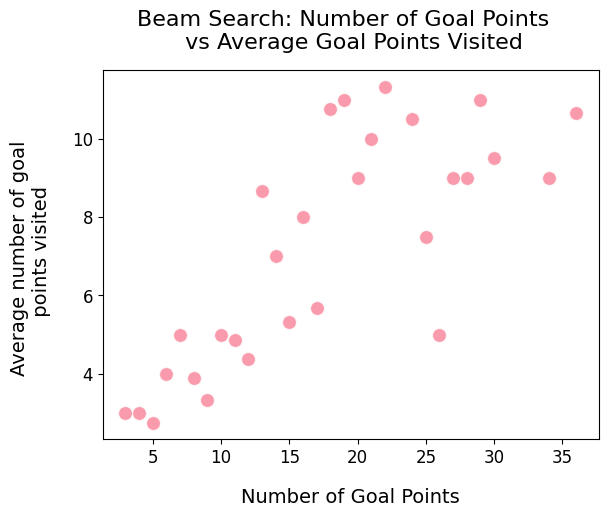

In [88]:
sns.scatterplot(
    data=merged_beam_number_goal_points_visited_df,
    x='number_goal_points',
    y='goals_visited',
    s=100,
    alpha=0.7,
)

# Set plot labels and title
plt.xlabel('Number of Goal Points', labelpad=15)
plt.ylabel('Average number of goal \n points visited', labelpad=15)
plt.title('Beam Search: Number of Goal Points  \n vs Average Goal Points Visited', pad=15)

In [ ]:
merged_beam_number_goal_points_visited_df

## Runtime

Tracked runtime for each instance by method is reported in: `./method_analysis/route_opt_results.csv`


```
Runtime Performance:
  annealing: 0.078296s avg, 7.8296s total
  beam: 0.008838s avg, 0.8838s total
  greedy: 0.001456s avg, 0.1456s total
  hybrid: 0.001694s avg, 0.1694s total
  local: 0.001676s avg, 0.1676s total
  ```

Annealing is the slowest (10x slower than the beam method)

The greedy, hybrid and local methods all have much faster execution times but the number of goal points visited is significantly lower than that achieved by the beam search.

To optimise each of the methods I looked to test/tweak the various parameter settings to optimise the number of goal points visited, I also implemented a 3-Opt method compared to the initial 2-Opt method to improve this primary metric, the beam method performed the best after these optimisations.


## Computational Complexity of the best performing method: beam search with 3-Opt search

The standard 3-Opt algorithm iterates over all possible triplets of edges (or nodes) in the path and considers the reconnection strategies for each. This yields a time complexity of: $ n^3 $, where `n` is the number of nodes in the tour.

Beam Search performs a breadth-first-like expansion, but only retains the top `B` candidates (beam width) at each depth up to maximum depth (number of goal insertions/search steps) `m`. This yields a time Complexity: $ O(B * m) $.

Combining these computational complexities for the overall method yields a time complexity of: $ O(B * m * n^3) $.


In [79]:
merged_beam_df

,instance,method,goals_visited,path_length,num_points,runtime,valid,number_goal_points,number_start_points,number_end_points,instance_number
0,instance_004,beam,4,1657.656,6,0.0004,1,8,2,4,instance_004
1,instance_001,beam,4,1447.594,6,0.0005,1,8,2,2,instance_001
2,instance_003,beam,4,1593.238,6,0.0005,1,5,4,4,instance_003
3,instance_002,beam,4,1900.835,6,0.0015,1,8,4,4,instance_002
4,instance_005,beam,3,1148.234,5,0.0002,1,4,4,3,instance_005
...,...,...,...,...,...,...,...,...,...,...,...
95,instance_096,beam,11,1937.753,13,0.0131,1,14,2,3,instance_096
96,instance_097,beam,6,1087.824,8,0.0008,1,7,1,1,instance_097
97,instance_098,beam,6,715.592,8,0.0014,1,6,1,1,instance_098
98,instance_099,beam,0,1796.051,2,0.0001,1,9,1,1,instance_099


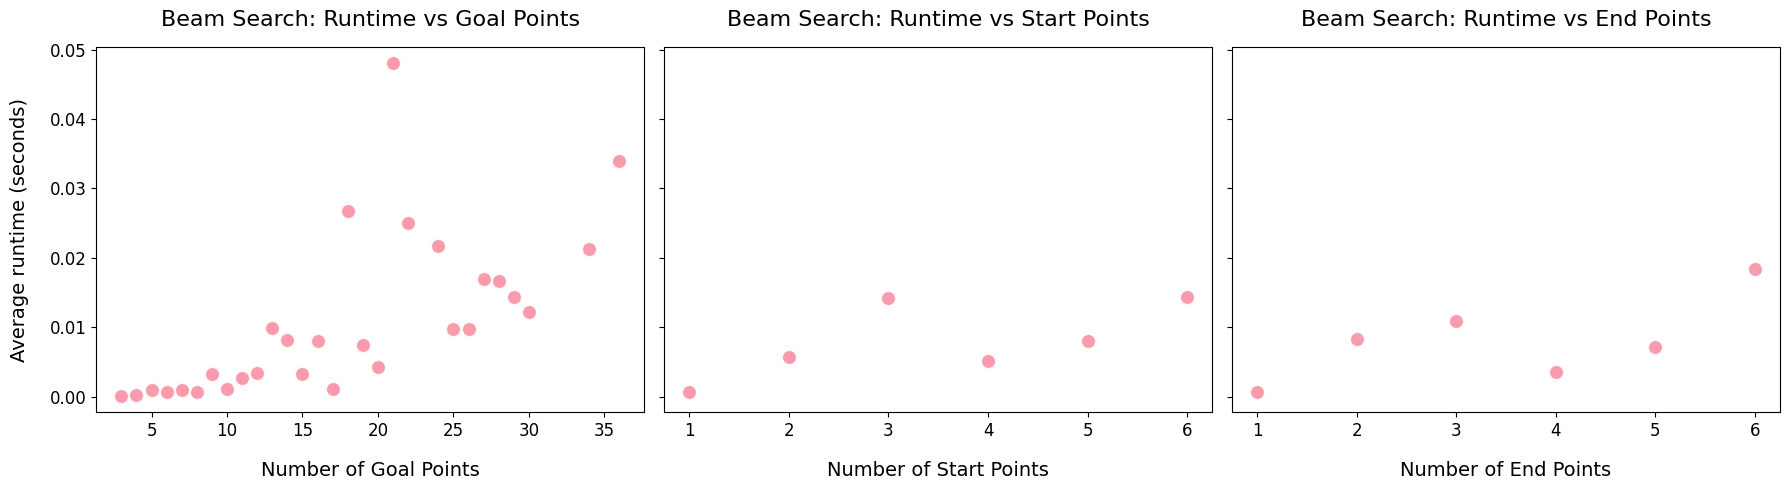

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True) 

sns.scatterplot(
    data=merged_beam_number_goals_df,
    x='number_goal_points',
    y='runtime',
    s=100,
    alpha=0.7,
    ax=axes[0]
)

# Set plot labels and title
axes[0].set_xlabel('Number of Goal Points', labelpad=15)
axes[0].set_ylabel('Average runtime (seconds)', labelpad=15)
axes[0].set_title('Beam Search: Runtime vs Goal Points', pad=15)

sns.scatterplot(
    data=merged_beam_number_starts_df,
    x='number_start_points',
    y='runtime',
    s=100,
    alpha=0.7,
    ax=axes[1]
)

# Set plot labels and title
axes[1].set_xlabel('Number of Start Points', labelpad=15)
axes[1].set_ylabel('Average runtime (seconds)', labelpad=15)
axes[1].set_title('Beam Search: Runtime vs Start Points', pad=15)

# Set plot labels and title
axes[0].set_xlabel('Number of Goal Points', labelpad=15)
axes[0].set_ylabel('Average runtime (seconds)', labelpad=15)
axes[0].set_title('Beam Search: Runtime vs Goal Points', pad=15)

sns.scatterplot(
    data=merged_beam_number_ends_df,
    x='number_end_points',
    y='runtime',
    s=100,
    alpha=0.7,
    ax=axes[2]
)

# Set plot labels and title
axes[2].set_xlabel('Number of End Points', labelpad=15)
axes[2].set_ylabel('Average runtime (seconds)', labelpad=15)
axes[2].set_title('Beam Search: Runtime vs End Points', pad=15)

# Display the legend
# plt.legend(title='Method')

# Show the plot
plt.tight_layout()
plt.show()

## Analysis for best performing method: Beam

- Trends show that increasing the number of goal points the instance has increases the average.

- Trends show that initially increasing the number of start points the instance has increases the runtime up to 3 start points and then the runtime drops for 4 start points before increasing again to 6 where the value reaches a similar average runtime that was seen for 3 start points.

- The same trend is seen for the number of end points that is seen for the number of start points.